In [ ]:
# Install libraries
!pip install pesq pystoi speechbrain jiwer ace-tools

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.8 MB/s eta 0:00:00
   ━

In [ ]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.linalg import svd
from scipy.signal import butter, sosfilt
from pesq import pesq
from pystoi import stoi
from speechbrain.inference.ASR import StreamingASR
import os
import glob
import pandas as pd
import re
from jiwer import wer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

dynchunktrain_config = DynChunkTrainConfig(
    chunk_size=1024,
    left_context_size=5
)


In [ ]:
# lyrics (manual entry)
lyrics = """It's the eye of the tiger, it's the thrill of the fight
Risin' up to the challenge of our rival
And the last known survivor stalks his prey in the night
And he's watching us all with the eye of the tiger
"""

# path to save
path = "/content/drive/MyDrive/SongProcessing/CleanSongsVocals/CleanTranscriptions/EyeOfTheTiger.txt"
os.makedirs(os.path.dirname(path), exist_ok=True)

# write out
with open(path, "w", encoding="utf-8") as f:
    f.write(lyrics)

print(f"lyrics saved → {path}")


Apply Spleeter to seperate vocals from beat.

In [ ]:
# load model
asr = StreamingASR.from_hparams(
    source="speechbrain/asr-streaming-conformer-librispeech",
    savedir="pretrained_models/asr-streaming-conformer-librispeech"
)

# song path
song_path = "/content/drive/MyDrive/SongProcessing/CleanSongsVocals/LoveIsBlind_vocals.wav"
x, sr = librosa.load(song_path, sr=16000)

# quick transcriber
def transcribe(x, sr):
    tmp = "temp.wav"
    sf.write(tmp, x, sr)
    out = asr.transcribe_file(tmp)
    os.remove(tmp)
    return out

# run it
out_txt = transcribe(x, sr)
print("\n--- transcript ---\n")
print(out_txt)

# baseline WER (vs itself)
w = wer(out_txt, transcribe(x, sr))
print("\n--- baseline WER (self) ---\n")
print(f"{w:.4f}")


hyperparams.yaml:   0%|          | 0.00/6.02k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/334M [00:00<?, ?B/s]

normalizer.ckpt:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

tokenizer.ckpt:   0%|          | 0.00/253k [00:00<?, ?B/s]


--- Transcription Output ---

IN ALL MY FRIENDS THINK I CRAZ OF A ZABANDO WHAT THEY DON'T KNOW THERE'S NOTHING NOR SUNKEN DO IT'S TOO BIG A LOT TOO BACK A LOVE AT LA TOO BAG A

--- Baseline WER ---

Baseline WER for LoveIsBlind.mp3: 0.0000


In [ ]:
# load model
asr = StreamingASR.from_hparams(
    source="speechbrain/asr-streaming-conformer-librispeech",
    savedir="pretrained_models/asr-streaming-conformer-librispeech"
)

# paths
base = "/content/drive/MyDrive/SongProcessing/CleanSongsVocals"
lyrics_dir = os.path.join(base, "CleanLyrics")
trans_dir = os.path.join(base, "Transcriptions")
wer_dir = os.path.join(base, "WER_Results")

os.makedirs(trans_dir, exist_ok=True)
os.makedirs(wer_dir, exist_ok=True)

# song list
songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

# transcriber
def transcribe(x, sr):
    tmp = "temp.wav"
    sf.write(tmp, x, sr)
    out = asr.transcribe_file(tmp)
    os.remove(tmp)
    return out

# run through each track
for song in songs:
    x_path = os.path.join(base, f"{song}_vocals.wav")
    lyr_path = os.path.join(lyrics_dir, f"{song}.txt")
    out_txt = os.path.join(trans_dir, f"{song}_ASR_Transcription.txt")
    out_wer = os.path.join(wer_dir, f"{song}_WER.txt")

    x, sr = librosa.load(x_path, sr=16000)
    hyp = transcribe(x, sr)

    with open(out_txt, "w") as f:
        f.write(hyp)
    print(f"[transcribed] → {out_txt}")

    with open(lyr_path, "r") as f:
        ref = f.read().strip()

    w = wer(ref, hyp)

    with open(out_wer, "w") as f:
        f.write(f"WER for {song}: {w:.4f}")
    print(f"[wer] {song}: {w:.4f} → {out_wer}")

print("\ndone.")


In [ ]:
# load model
asr = StreamingASR.from_hparams(
    source="speechbrain/asr-streaming-conformer-librispeech",
    savedir="pretrained_models/asr-streaming-conformer-librispeech"
)

# paths
base = "/content/drive/MyDrive/SongProcessing"
trans_dir = os.path.join(base, "CleanSongsVocals", "Transcriptions")

# songs
songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

# transcriber
def transcribe(x, sr):
    tmp = "temp.wav"
    sf.write(tmp, x, sr)
    out = asr.transcribe_file(tmp)
    os.remove(tmp)
    return out

# log WERs
log = []

# go through each song's noisy versions
for song in songs:
    noisy_dir = os.path.join(base, f"{song}_Noisy")
    ref_path = os.path.join(trans_dir, f"{song}_ASR_Transcription.txt")

    trans_out = os.path.join(noisy_dir, "Transcriptions")
    wer_out = os.path.join(noisy_dir, "Noisy_WER")
    os.makedirs(trans_out, exist_ok=True)
    os.makedirs(wer_out, exist_ok=True)

    with open(ref_path, "r") as f:
        ref = f.read().strip()

    files = glob.glob(os.path.join(noisy_dir, "*.wav"))
    for fpath in files:
        name = os.path.basename(fpath).replace(".wav", "")
        x, sr = librosa.load(fpath, sr=16000)

        hyp = transcribe(x, sr)

        # save txt
        out_txt = os.path.join(trans_out, f"NoisyTranscription_{name}.txt")
        with open(out_txt, "w") as f:
            f.write(hyp)

        # calc WER
        w = wer(ref, hyp)

        # save WER txt
        out_wer = os.path.join(wer_out, f"WER_Noisy_{name}.txt")
        with open(out_wer, "w") as f:
            f.write(f"WER for {name}: {w:.4f}")

        log.append({
            "Song": song,
            "File": name,
            "WER (Noisy vs Clean ASR)": w
        })

# drop to csv
df = pd.DataFrame(log)
out_csv = os.path.join(base, "WER_Noisy_vs_CleanASR_Results.csv")
df.to_csv(out_csv, index=False)

print("noisy music transcriptions + WERs saved.")


This Computes WER (Clean Vocals ASR vs Correct Lyrics) Use this as bias for when we graph.

In [ ]:
# paths
base = "/content/drive/MyDrive/SongProcessing"
asr_dir = os.path.join(base, "CleanSongsVocals", "Transcriptions")
lyrics_dir = os.path.join(base, "CleanSongsVocals", "CleanLyrics")

songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

log = []

for song in songs:
    asr_path = os.path.join(asr_dir, f"{song}_ASR_Transcription.txt")
    lyr_path = os.path.join(lyrics_dir, f"{song}.txt")

    if not os.path.exists(asr_path) or not os.path.exists(lyr_path):
        print(f"skip → {song} (missing file)")
        continue

    with open(asr_path, "r") as f:
        hyp = f.read().strip()
    with open(lyr_path, "r") as f:
        ref = f.read().strip()

    w = wer(ref, hyp)

    log.append({
        "Song": song,
        "WER (ASR vs Lyrics)": w
    })

# df + normalize
df = pd.DataFrame(log)
scaler = MinMaxScaler()
df["WER Normalized"] = scaler.fit_transform(df[["WER (ASR vs Lyrics)"]])

# dump to CSV
out_csv = os.path.join(base, "WER_CleanVocals_vs_Lyrics_BIAS.csv")
df.to_csv(out_csv, index=False)

print(f"saved → {out_csv}")


In [ ]:
# paths
base = "/content/drive/MyDrive/SongProcessing"
thresh_dir = os.path.join(base, "OptimalThresholds")
os.makedirs(thresh_dir, exist_ok=True)

songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

# threshold finder
def get_svd_rank(x, sr):
    spec = librosa.stft(x)
    _, S, _ = np.linalg.svd(spec, full_matrices=False)
    energy = np.cumsum(S**2) / np.sum(S**2)
    return np.argmax(energy >= 0.95)

log = []

for song in songs:
    folder = os.path.join(base, f"{song}_Noisy")
    if not os.path.exists(folder):
        print(f"skip → {song} (no noisy folder)")
        continue

    files = librosa.util.find_files(folder, ext=["wav"])
    for f in files:
        name = os.path.basename(f).replace(".wav", "")
        x, sr = librosa.load(f, sr=16000)
        k = get_svd_rank(x, sr)

        out_txt = os.path.join(thresh_dir, f"Threshold_{name}.txt")
        with open(out_txt, "w") as w:
            w.write(str(k))

        log.append({
            "Song": song,
            "File": name,
            "Optimal Threshold": k
        })

# save all
df = pd.DataFrame(log)
out_csv = os.path.join(thresh_dir, "SVD_Thresholds.csv")
df.to_csv(out_csv, index=False)

print(f"saved → {out_csv}")


In [ ]:
# paths
base = "/content/drive/MyDrive/SongProcessing"
thresh_dir = os.path.join(base, "OptimalThresholds")
den_dir = os.path.join(base, "DenoisedSongs")
os.makedirs(den_dir, exist_ok=True)

songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

# apply SVD
def svd_denoise(x, sr, k):
    spec = librosa.stft(x)
    U, S, V = np.linalg.svd(spec, full_matrices=False)
    S[k:] = 0
    cleaned = U @ np.diag(S) @ V
    return librosa.istft(cleaned)

# process each
for song in songs:
    noisy_dir = os.path.join(base, f"{song}_Noisy")
    out_dir = os.path.join(den_dir, f"{song}_Denoised")
    os.makedirs(out_dir, exist_ok=True)

    if not os.path.exists(noisy_dir):
        print(f"skip → {song} (no noisy dir)")
        continue

    files = librosa.util.find_files(noisy_dir, ext=["wav"])
    for f in files:
        name = os.path.basename(f)
        x, sr = librosa.load(f, sr=16000)

        t_path = os.path.join(thresh_dir, f"Threshold_{name.replace('.wav','')}.txt")
        if not os.path.exists(t_path):
            print(f"skip → {name} (no threshold)")
            continue

        with open(t_path, "r") as t:
            k = int(t.read().strip())

        x_d = svd_denoise(x, sr, k)
        sf.write(os.path.join(out_dir, name), x_d, sr)

print("denoised songs saved.")


In [ ]:
# load model
asr = StreamingASR.from_hparams(
    source="speechbrain/asr-streaming-conformer-librispeech",
    savedir="pretrained_models/asr-streaming-conformer-librispeech"
)

# paths
base = "/content/drive/MyDrive/SongProcessing"
ref_dir = os.path.join(base, "CleanSongsVocals", "Transcriptions")
trans_out = os.path.join(base, "DenoisedTranscriptions")
wer_out = os.path.join(base, "WER_Results")
thresh_dir = os.path.join(base, "OptimalThresholds")
os.makedirs(trans_out, exist_ok=True)
os.makedirs(wer_out, exist_ok=True)

songs = [
    "LoveIsBlind",
    "ItAMansWorld",
    "IsThisLove",
    "Frontin",
    "familyAffair",
    "EyeOfTheTiger"
]

# transcriber
def transcribe(x, sr):
    tmp = "temp.wav"
    sf.write(tmp, x, sr)
    out = asr.transcribe_file(tmp)
    os.remove(tmp)
    return out

log = []

for song in songs:
    noisy_dir = os.path.join(base, f"{song}_Noisy")
    den_dir = os.path.join(noisy_dir, "Denoised")
    ref_path = os.path.join(ref_dir, f"{song}_ASR_Transcription.txt")
    t_csv = os.path.join(thresh_dir, f"OptimalThresholds_{song}.csv")

    if not os.path.exists(den_dir):
        print(f"skip → {song} (no denoised dir)")
        continue
    if not os.path.exists(t_csv):
        print(f"skip → {song} (no threshold csv)")
        continue

    with open(ref_path, "r") as f:
        ref = f.read().strip()
    t_df = pd.read_csv(t_csv, index_col="File")

    files = glob.glob(os.path.join(den_dir, "*.wav"))
    for fpath in files:
        name = os.path.basename(fpath).replace(".wav", "")
        x, sr = librosa.load(fpath, sr=16000)
        hyp = transcribe(x, sr)

        # save transcript
        out_txt = os.path.join(trans_out, f"DenoisedTranscription_{name}.txt")
        with open(out_txt, "w") as f:
            f.write(hyp)

        # calc WER
        w = wer(ref, hyp)

        # save WER txt
        out_wer = os.path.join(wer_out, f"WER_Denoised_{name}.txt")
        with open(out_wer, "w") as f:
            f.write(f"WER for {name}: {w:.4f}")

        log.append({
            "Song": song,
            "File": name,
            "WER (Denoised vs Clean ASR)": w,
            "Optimal Threshold": t_df.loc[name, "Optimal Threshold"] if name in t_df.index else "N/A"
        })

# dump csv
df = pd.DataFrame(log)
out_csv = os.path.join(wer_out, "WER_Denoised_vs_CleanASR_Results.csv")
df.to_csv(out_csv, index=False)

print(f"denoised WERs saved → {out_csv}")


In [ ]:
# load model
asr = StreamingASR.from_hparams(
    source="speechbrain/asr-streaming-conformer-librispeech",
    savedir="pretrained_models/asr-streaming-conformer-librispeech"
)

# paths
base = "/content/drive/MyDrive/SongProcessing"
den_dir = os.path.join(base, "DenoisedSongs")
ref_dir = os.path.join(base, "CleanSongsVocals", "Transcriptions")
out_dir = os.path.join(base, "WER_Results")
os.makedirs(out_dir, exist_ok=True)

# transcriber
def transcribe(x, sr):
    tmp = "temp.wav"
    sf.write(tmp, x, sr)
    out = asr.transcribe_file(tmp)
    os.remove(tmp)
    return out

log = []

# go through all *_Denoised folders
folders = sorted(glob.glob(os.path.join(den_dir, "*_Denoised")))
for folder in folders:
    song = os.path.basename(folder).replace("_Denoised", "")
    ref_path = os.path.join(ref_dir, f"{song}_ASR_Transcription.txt")
    if not os.path.exists(ref_path):
        print(f"skip → {song} (no reference)")
        continue

    with open(ref_path, "r") as f:
        ref = f.read().strip()

    trans_dir = os.path.join(folder, "Transcriptions")
    wer_dir = os.path.join(folder, "Denoised_WER")
    os.makedirs(trans_dir, exist_ok=True)
    os.makedirs(wer_dir, exist_ok=True)

    files = glob.glob(os.path.join(folder, "*.wav"))
    for fpath in files:
        name = os.path.basename(fpath).replace(".wav", "")
        x, sr = librosa.load(fpath, sr=16000)
        hyp = transcribe(x, sr)

        # save transcription
        with open(os.path.join(trans_dir, f"DenoisedTranscription_{name}.txt"), "w") as f:
            f.write(hyp)

        # calc WER
        w = wer(ref, hyp)
        with open(os.path.join(wer_dir, f"WER_Denoised_{name}.txt"), "w") as f:
            f.write(f"WER for {name}: {w:.4f}")

        log.append({
            "Song": song,
            "File": name,
            "WER (Denoised vs Clean Vocals)": w
        })

# save CSV
df = pd.DataFrame(log)
df.to_csv(os.path.join(out_dir, "WER_Denoised_vs_CleanVocals.csv"), index=False)

print("done saving denoised WERs.")


Denoised song transcriptions and WER results saved successfully.


In [ ]:
# paths
base = "/content/drive/MyDrive/SongProcessing"
noisy_dir = base
den_dir = os.path.join(base, "DenoisedSongs")
out_dir = os.path.join(base, "WER_Results")
os.makedirs(out_dir, exist_ok=True)

log = []

# get folders
noisy_folders = sorted(glob.glob(os.path.join(noisy_dir, "*_Noisy")))
denoised_folders = sorted(glob.glob(os.path.join(den_dir, "*_Denoised")))

if len(noisy_folders) != len(denoised_folders):
    print("⚠ folder count mismatch")

for d_folder in denoised_folders:
    song = os.path.basename(d_folder).replace("_Denoised", "")
    n_folder = os.path.join(noisy_dir, f"{song}_Noisy")

    if not os.path.exists(n_folder):
        print(f"skip → {song} (no noisy folder)")
        continue

    n_txt_dir = os.path.join(n_folder, "Transcriptions")
    d_txt_dir = os.path.join(d_folder, "Transcriptions")
    out_txt_dir = os.path.join(d_folder, "WER_Noisy_vs_Denoised")
    os.makedirs(out_txt_dir, exist_ok=True)

    if not os.path.exists(n_txt_dir):
        print(f"skip → {song} (no noisy transcripts)")
        continue

    d_files = glob.glob(os.path.join(d_txt_dir, "*.txt"))
    for d_path in d_files:
        name = os.path.basename(d_path).replace("DenoisedTranscription_", "").replace(".txt", "")
        n_path = os.path.join(n_txt_dir, f"NoisyTranscription_{name}.txt")
        if not os.path.exists(n_path):
            print(f"no match for {name} in noisy")
            continue

        with open(d_path, "r") as f:
            d_txt = f.read().strip()
        with open(n_path, "r") as f:
            n_txt = f.read().strip()

        if not n_txt or not d_txt:
            print(f"skip → {name} (empty transcript)")
            continue

        w = wer(n_txt, d_txt)
        with open(os.path.join(out_txt_dir, f"WER_Noisy_vs_Denoised_{name}.txt"), "w") as f:
            f.write(f"WER (Noisy vs. Denoised) for {name}: {w:.4f}")

        log.append({
            "Song": song,
            "File": name,
            "WER (Noisy vs. Denoised)": w
        })

# dump to csv
df = pd.DataFrame(log)
df.to_csv(os.path.join(out_dir, "WER_Noisy_vs_Denoised.csv"), index=False)

print("noisy vs denoised WERs saved.")


Skipping EyeOfTheTiger_vocals_with_Typing_3_SNR_0dB - One of the transcriptions is empty.
Skipping EyeOfTheTiger_vocals_with_VacuumCleaner_3_SNR_0dB - One of the transcriptions is empty.
Skipping LoveIsBlind_vocals_with_AirConditioner_1_SNR_0dB - One of the transcriptions is empty.
Skipping LoveIsBlind_vocals_with_Babble_8_SNR_0dB - One of the transcriptions is empty.
Skipping LoveIsBlind_vocals_with_Typing_3_SNR_0dB - One of the transcriptions is empty.
Skipping LoveIsBlind_vocals_with_VacuumCleaner_3_SNR_0dB - One of the transcriptions is empty.
Skipping familyAffair_vocals_with_AirConditioner_1_SNR_0dB - One of the transcriptions is empty.
WER (Noisy vs. Denoised) results saved successfully.


In [ ]:
import pandas as pd

# paths
base = "/content/drive/MyDrive/SpeechProcessing/WER_Results/"

# load csvs
df_noisy = pd.read_csv(base + "WER_Noisy_Results.csv")
df_denoised = pd.read_csv(base + "WER_Denoised_Results.csv")
df_diff = pd.read_csv(base + "WER_Noisy_vs_Denoised.csv")

# show samples
print("\nNoisy vs Denoised:")
print(df_diff.head())

print("\nClean vs Noisy:")
print(df_noisy.head())

print("\nClean vs Denoised:")
print(df_denoised.head())


In [ ]:
# compute means
mean_noisy = df_noisy["WER (Noisy)"].mean()
mean_denoised = df_denoised["WER (Denoised)"].mean()
mean_diff = df_diff["WER (Noisy vs. Denoised)"].mean()

# compute percent changes
gain = ((mean_noisy - mean_denoised) / mean_noisy) * 100
delta = ((mean_noisy - mean_diff) / mean_noisy) * 100

# show results
print("\navg WERs:")
print(f"clean vs noisy     → {mean_noisy:.4f}")
print(f"clean vs denoised  → {mean_denoised:.4f}")
print(f"noisy vs denoised  → {mean_diff:.4f}")

print("\nrelative change:")
print(f"↑ improved vs clean    → {gain:.2f}%")
print(f"↔ shift from noisy     → {delta:.2f}%")


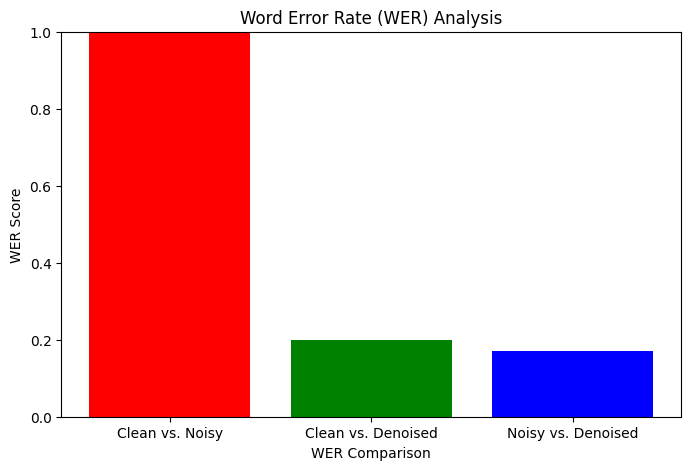

In [ ]:
labels = ["Clean vs Noisy", "Clean vs Denoised", "Noisy vs Denoised"]
scores = [mean_noisy, mean_denoised, mean_diff]

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=["#d9534f", "#5cb85c", "#5bc0de"])
plt.ylabel("WER")
plt.title("WER Comparison Across Processing Stages")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# base dirs
base = "/content/drive/MyDrive/SpeechProcessing"
noisy_dirs = [f"{base}/NoisySpeech{i or ''}/" for i in range(6)]
denoised_dirs = [f"{base}/DenoisedSpeech/DenoisedSpeech{i+1}/" for i in range(6)]

# utils
def extract_noise_info(name):
    m = re.search(r"with_([A-Za-z]+)_\d+_SNR_(-?\d+)dB", name)
    return (m.group(1), int(m.group(2))) if m else (None, None)

def extract_wer_from_file(path):
    with open(path, "r") as f:
        content = f.read().strip()
    m = re.search(r"([\d\.]+)", content)
    return float(m.group(1)) if m else None

# collect noisy WERs
noisy_data = {}
for d in noisy_dirs:
    files = glob.glob(os.path.join(d, "Noisy_WER", "*.txt"))
    for f in files:
        name = os.path.basename(f)
        ntype, snr = extract_noise_info(name)
        if ntype:
            noisy_data[name] = {
                "Noise Type": ntype,
                "Noise Level (dB)": snr,
                "WER Noisy": extract_wer_from_file(f)
            }

# collect denoised WERs (assumes similar filenames)
denoised_data = {}
for d in denoised_dirs:
    files = glob.glob(os.path.join(d, "Denoised_WER", "*.txt"))
    for f in files:
        name = os.path.basename(f).replace("WER_Denoised_", "")
        ntype, snr = extract_noise_info(name)
        if ntype:
            denoised_data[name] = {
                "Noise Type": ntype,
                "Noise Level (dB)": snr,
                "WER Denoised": extract_wer_from_file(f)
            }

# check matches
print("\nchecking noisy ↔ denoised matches:")
for i, fname in enumerate(noisy_data.keys()):
    if fname in denoised_data:
        print(f"[✓] {fname}")
    else:
        print(f"[x] {fname}")
    if i == 4: break  # just show 5


In [ ]:
# paths
base = "/content/drive/MyDrive/SongProcessing/WER_Results"
p1 = os.path.join(base, "WER_Denoised_vs_CleanVocals.csv")
p2 = os.path.join(base, "WER_Noisy_vs_CleanASR_Results.csv")
p3 = os.path.join(base, "WER_Noisy_vs_Denoised.csv")

# load
df1 = pd.read_csv(p1)
df2 = pd.read_csv(p2)
df3 = pd.read_csv(p3)

# noise info extractor
def extract_noise_info(name):
    m = re.search(r"with_([A-Za-z]+)_\d+_SNR_(-?\d+)dB", name)
    return pd.Series((m.group(1), int(m.group(2)))) if m else pd.Series((None, None))

# annotate all
for df in [df1, df2, df3]:
    df[["Noise Type", "Noise Level (dB)"]] = df["File"].apply(extract_noise_info)

# merge
df = df2.merge(df1, on=["Song", "File", "Noise Type", "Noise Level (dB)"], how="outer")
df = df.merge(df3, on=["Song", "File", "Noise Type", "Noise Level (dB)"], how="outer")

# save
out_path = os.path.join(base, "Formatted_WER_Results.csv")
df.to_csv(out_path, index=False)

print(df.head())
print(f"formatted WER → {out_path}")


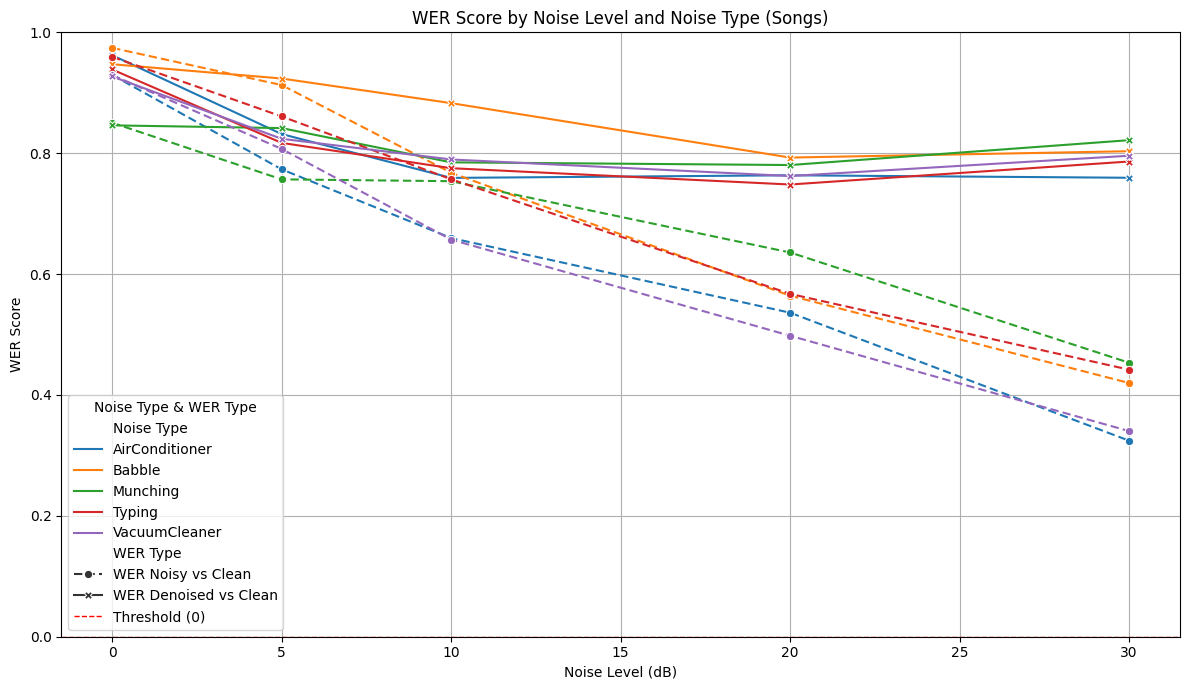

In [ ]:
# load
base = "/content/drive/MyDrive/SongProcessing/WER_Results"
df = pd.read_csv(os.path.join(base, "Formatted_WER_Results.csv"))

# fix col names if needed
df.rename(columns={
    'WER (Noisy vs Clean ASR)': 'WER Noisy vs Clean',
    'WER (Denoised vs Clean Vocals)': 'WER Denoised vs Clean'
}, inplace=True)

# avg by type + SNR
avg = df.groupby(['Noise Level (dB)', 'Noise Type'])[
    ['WER Noisy vs Clean', 'WER Denoised vs Clean']
].mean().reset_index()

# reshape for seaborn
melted = avg.melt(
    id_vars=['Noise Level (dB)', 'Noise Type'],
    value_vars=['WER Noisy vs Clean', 'WER Denoised vs Clean'],
    var_name='WER Type',
    value_name='WER'
)

# style options
styles = {
    'WER Noisy vs Clean': (4, 2),
    'WER Denoised vs Clean': ""
}

# plot
plt.figure(figsize=(11, 6))
sns.lineplot(data=melted, x='Noise Level (dB)', y='WER',
             hue='Noise Type', style='WER Type',
             markers=True, dashes=styles)

plt.axhline(0, ls='--', lw=1, c='gray')
plt.title("WER by Noise Level and Type (Songs)")
plt.xlabel("SNR (dB)")
plt.ylabel("WER")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Noise / WER Type")
plt.tight_layout()
plt.show()
